# RED Wine Prediction 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as ex
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, auc

# Ignore useless warnings
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
df = pd.read_csv('winequality-red.csv')

### EDA

In [3]:
df.shape

(1599, 12)

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Plot relationship between variables

<AxesSubplot:>

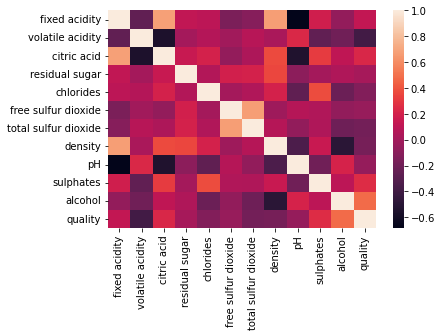

In [7]:
corr = df.corr()
sns.heatmap(corr)

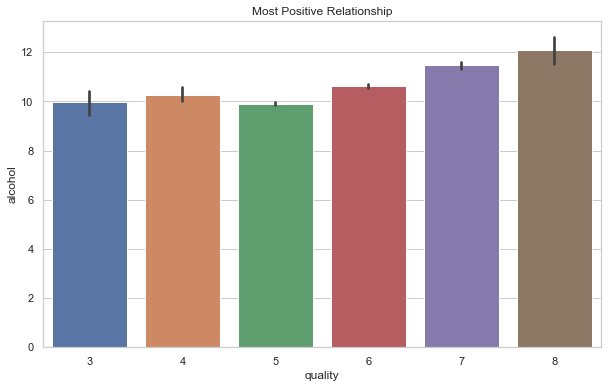

In [8]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x="quality", y="alcohol", data=df)
plt.title("Most Positive Relationship")
ax.set_xlabel("quality")
ax.set_ylabel("alcohol")
plt.show()

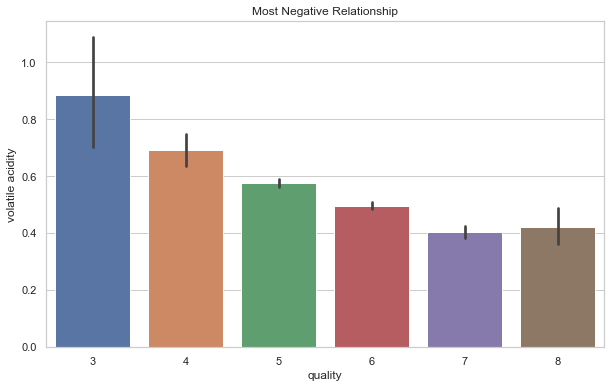

In [9]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x="quality", y="volatile acidity", data=df)
plt.title("Most Negative Relationship")
ax.set_xlabel("quality")
ax.set_ylabel("volatile acidity")
plt.show()


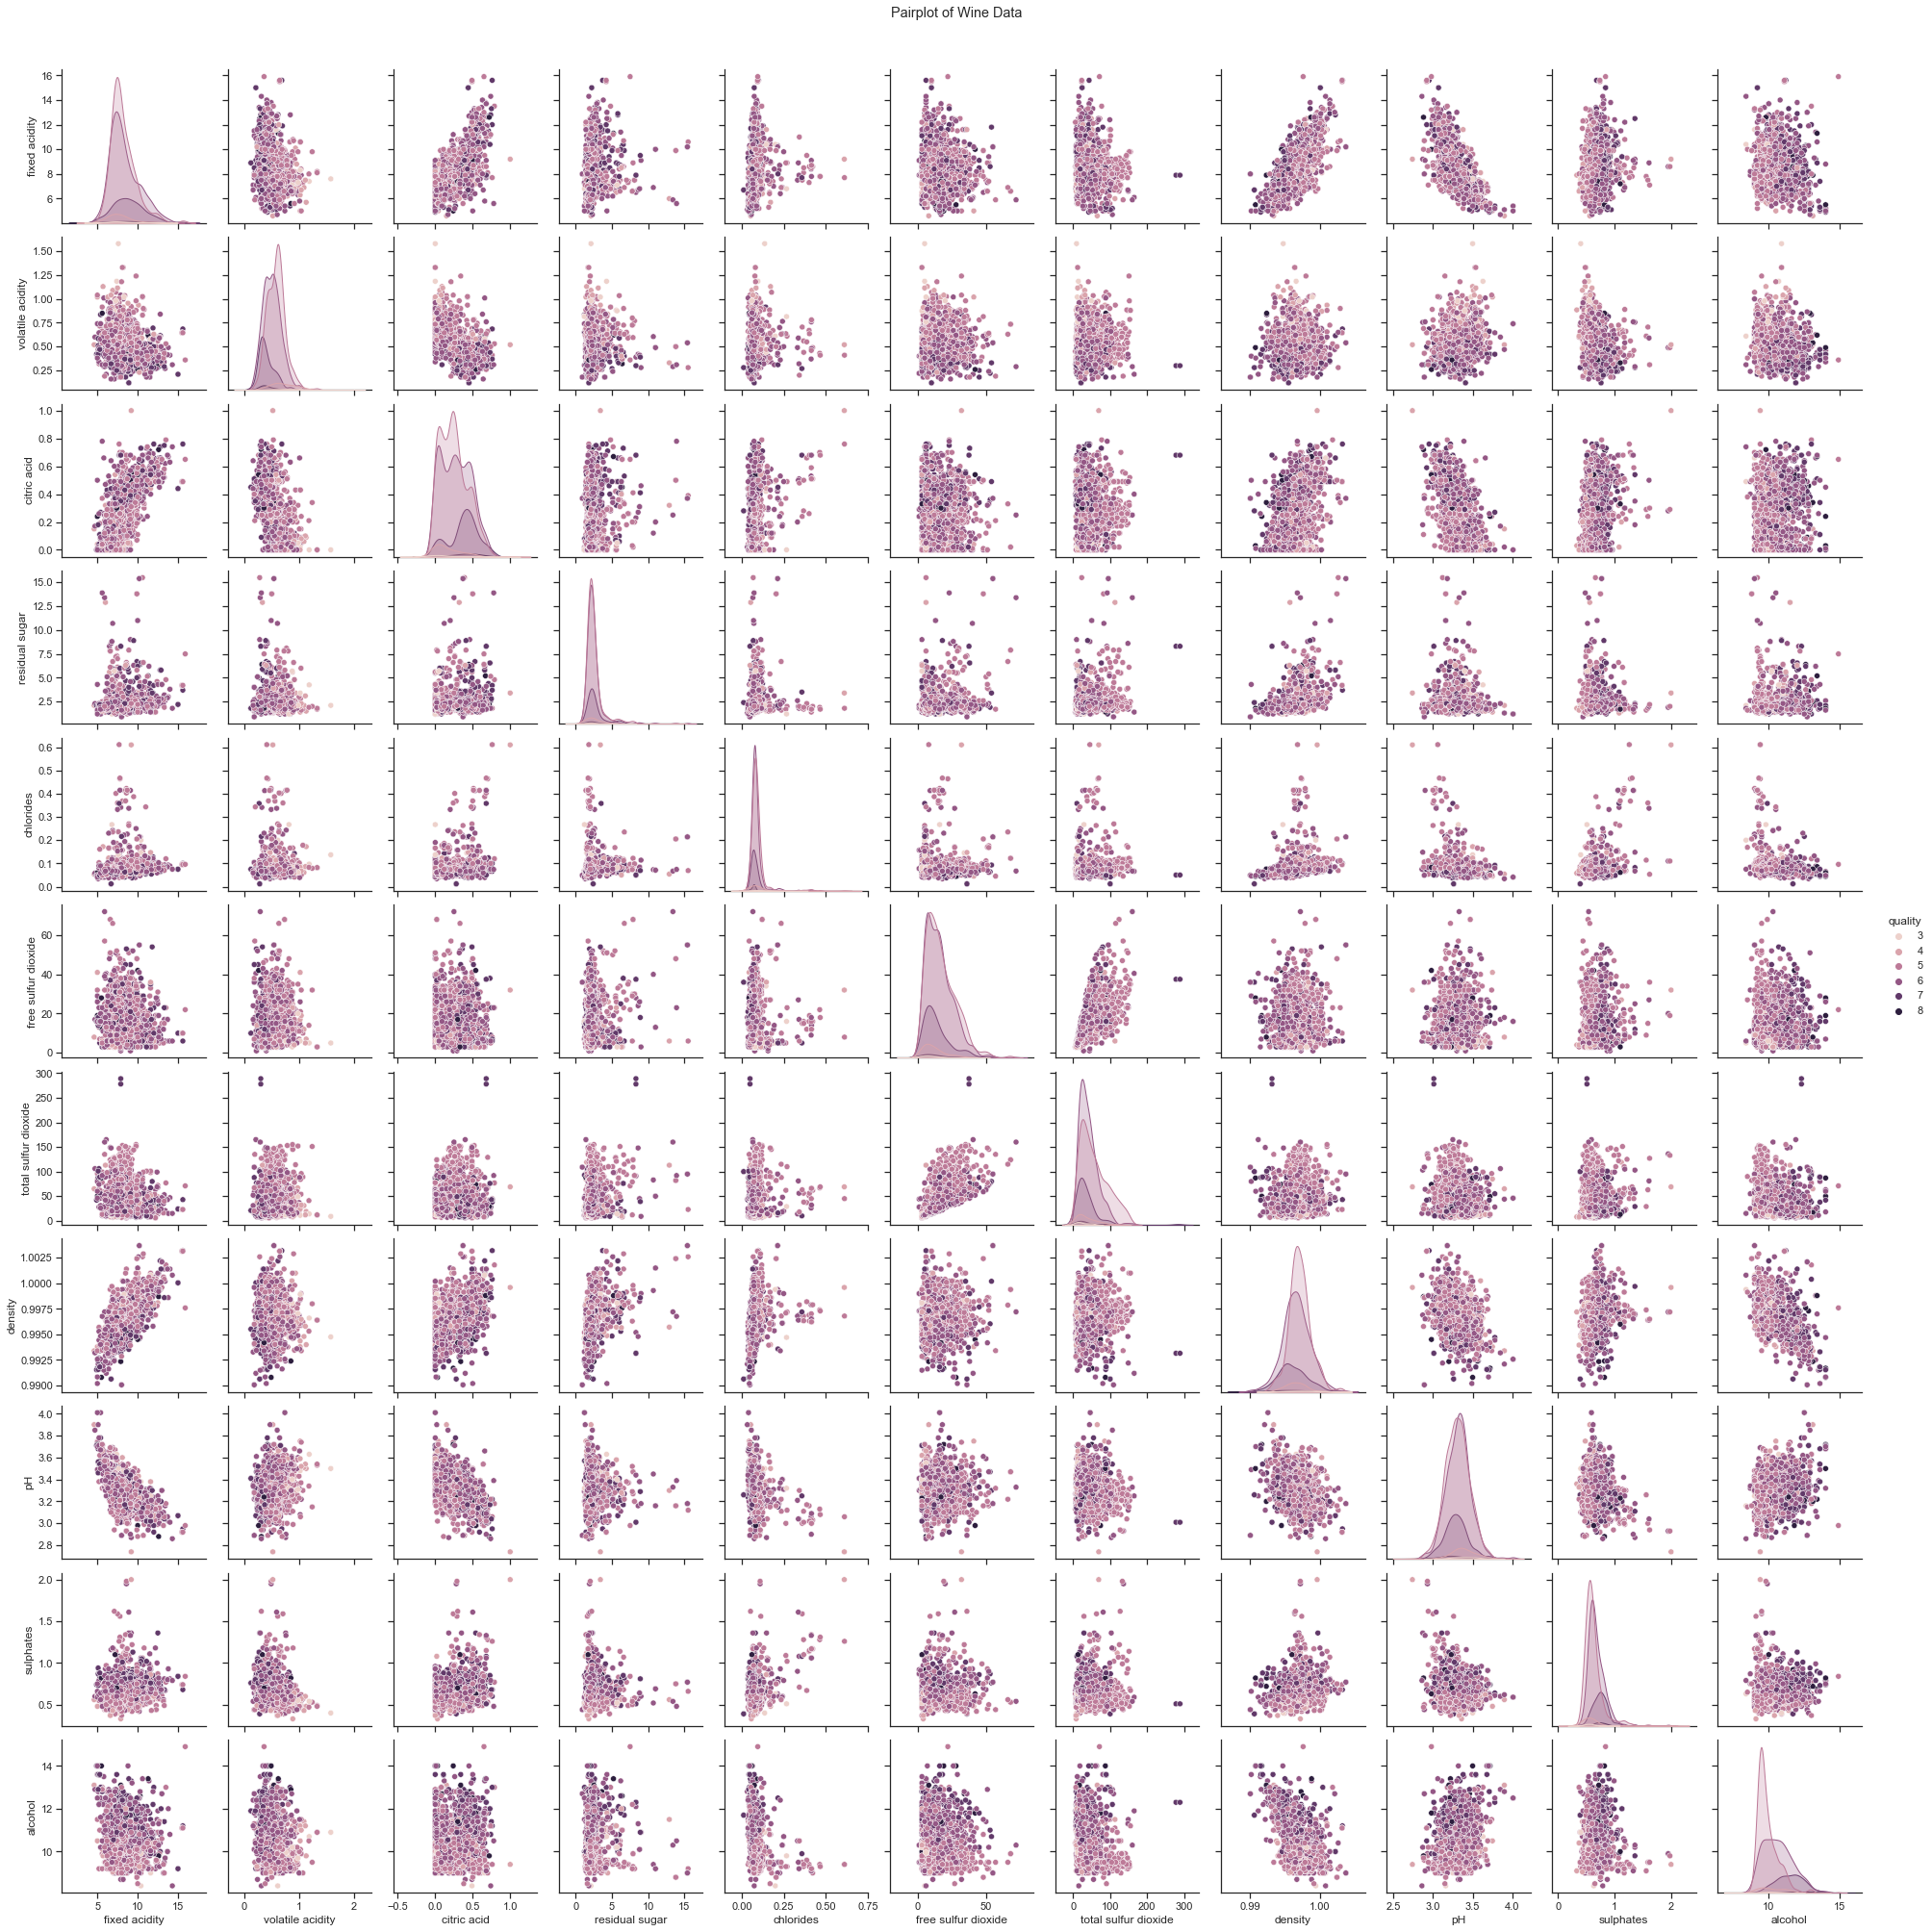

In [10]:

sns.set(style="ticks")
sns.pairplot(df, diag_kind="kde", markers="o", hue="quality")

plt.suptitle("Pairplot of Wine Data", y=1.02)
plt.show()

### Data Cleaning

In [11]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [12]:
df.duplicated().sum()

240

In [13]:
df=df.drop_duplicates()

### 7 or higher get classified as 'good/1' and the remainder as 'not good/0'

In [14]:
df["quality"] = np.where(df["quality"] >= 7, 1, 0)
df['quality'].value_counts()

0    1175
1     184
Name: quality, dtype: int64

### Prediction Model

In [15]:
X = df.drop('quality', axis=1)
y = df['quality']

### Splitting the data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Normalization 

   ### Feature Scaling

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(pd.Series(y_train).value_counts())

1    937
0    937
Name: quality, dtype: int64


## Prediction Model

### Random Forest

In [22]:
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display a classification report for more detailed metrics
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       238
           1       0.47      0.68      0.55        34

    accuracy                           0.86       272
   macro avg       0.71      0.78      0.74       272
weighted avg       0.89      0.86      0.87       272



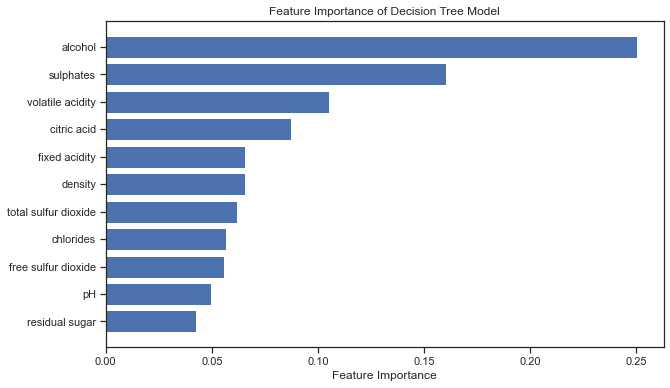

In [23]:
# Get feature importances
feature_importance = rf.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = feature_importance.argsort()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Decision Tree Model')
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'n_estimators': 150}
Best Accuracy: 0.9295643493761141
